<a href="https://colab.research.google.com/github/nguyen-nhat-mai/object_detection/blob/main/Rotate_img_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotating image & box in YOLO format

In [1]:
import cv2
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from decimal import Decimal
import random

In [19]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd

Mounted at /content/gdrive
/content


## Define function to rotate image & box in YOLO format

https://usmanr149.github.io/urmlblog/yolo/2020/03/05/rotate_yolo_bbox.html

In [3]:
# Convert box coordinate from yolo to cv
def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H
    cv = []
    cv.append(center_x - (bbox_width / 2))
    cv.append(center_y - (bbox_height / 2))
    cv.append(center_x + (bbox_width / 2))
    cv.append(center_y + (bbox_height / 2))
    return [int(v) for v in cv]

In [4]:
# Plot yolo box
box_color = {0:'blue',1:'orange',2:'green',3:'purple',4:'brown',5:'pink',
             6:'gray',7:'olive',8:'cyan',9:'gold',10:'turquoise',11:'navy',12:'yellow',13:'red'}
box_name = {0:'RazorBlade',1:'SafetyPin',2:'PaperClip',3:'Pen',4:'ThinNail',5:'Screw',
            6:'HandGun',7:'VgaConnector',8:'Knife',9:'MultiPurposeKnife',10:'Key',11:'Plier',12:'Shuriken',13:'Scissor'}
def plot_box(box_yolo_coordinates, height, width):
  ''' Input: list of boxes
      Output: plot of boxes'''
  for row in box_yolo_coordinates:
    bbox = row.strip('\n').split(' ')
    [x1,y1,x2,y2] = yoloFormattocv(Decimal(bbox[1]),Decimal(bbox[2]),Decimal(bbox[3]),Decimal(bbox[4]),height, width)
    plt.gca().add_patch(Rectangle((x1,y1),x2-x1,y2-y1, edgecolor=box_color[int(bbox[0])], facecolor='none', lw=1))
    plt.annotate(box_name[int(bbox[0])], ((x2+x1)/2, (y2+y1)/2), 
                 color=box_color[int(bbox[0])], weight='bold', fontsize=10, ha='center', va='center') # label at the center of the box

In [5]:
def cvFormattoYolo(corner, H, W):
    ''' Input: list of coordinates in cv format ['label','x1','y1','x2','y2']
        Output: list of coordinates in yolo format 'label x_center y_center box_width box_height' '''
    bbox_W = corner[3] - corner[1]
    bbox_H = corner[4] - corner[2]

    center_bbox_x = (corner[1] + corner[3]) / 2
    center_bbox_y = (corner[2] + corner[4]) / 2

    return corner[0]+' '+str(round(center_bbox_x / W, 6))+' '+str(round(center_bbox_y / H, 6))+' '+str(round(bbox_W / W, 6))+' '+str(round(bbox_H / H, 6))

In [6]:
class yoloRotatebbox:
    def __init__(self, img_folder_path, box_folder_path,filename, image_ext, angle):
        assert os.path.isfile(img_folder_path + "/" + filename + image_ext)
        assert os.path.isfile(box_folder_path + "/" + filename + '.txt')

        self.img_folder_path = img_folder_path
        self.box_folder_path = box_folder_path
        self.filename = filename
        self.image_ext = image_ext
        self.angle = angle

        # Read image using cv2
        self.image = cv2.imread(self.img_folder_path + "/" + self.filename + self.image_ext, 1)

        # create a 2D-rotation matrix
        rotation_angle = self.angle * np.pi / 180
        self.rot_matrix = np.array(
            [[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
        
    def rotate_image(self):
        """
        Rotates an image (angle in degrees) and expands image to avoid cropping
        """
        height, width = self.image.shape[:2]  # image shape has 3 dimensions
        image_center = (width / 2,
                        height / 2)  # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

        rotation_mat = cv2.getRotationMatrix2D(image_center, self.angle, 1.)

        # rotation calculates the cos and sin, taking absolutes of those.
        abs_cos = abs(rotation_mat[0, 0])
        abs_sin = abs(rotation_mat[0, 1])

        # find the new width and height bounds
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)

        # subtract old image center (bringing image back to origin) and adding the new image center coordinates
        rotation_mat[0, 2] += bound_w / 2 - image_center[0]
        rotation_mat[1, 2] += bound_h / 2 - image_center[1]

        # rotate image with the new bounds and translated rotation matrix
        rotated_mat = cv2.warpAffine(self.image, rotation_mat, (bound_w, bound_h))
        return rotated_mat

    def rotateYolobbox(self):

        new_height, new_width = self.rotate_image().shape[:2]
        f = open(self.box_folder_path + "/" + self.filename + '.txt', 'r')
        f1 = f.readlines()

        yolo_bbox = []

        H, W = self.image.shape[:2]

        for x in f1:
            bbox = x.strip('\n').split(' ')
            if len(bbox) > 1:
                (center_x, center_y, bbox_width, bbox_height) = yoloFormattocv(float(bbox[1]), float(bbox[2]),
                                                                               float(bbox[3]), float(bbox[4]), H, W)
                
                # shift the origin to the center of the image.
                upper_left_corner_shift = (center_x - W / 2, -H / 2 + center_y)
                upper_right_corner_shift = (bbox_width - W / 2, -H / 2 + center_y)
                lower_left_corner_shift = (center_x - W / 2, -H / 2 + bbox_height)
                lower_right_corner_shift = (bbox_width - W / 2, -H / 2 + bbox_height)

                new_lower_right_corner = [-1, -1]
                new_upper_left_corner = []

                for i in (upper_left_corner_shift, upper_right_corner_shift, lower_left_corner_shift,
                          lower_right_corner_shift):
                    new_coords = np.matmul(self.rot_matrix, np.array((i[0], -i[1])))
                    x_prime, y_prime = new_width / 2 + new_coords[0], new_height / 2 - new_coords[1]
                    if new_lower_right_corner[0] < x_prime:
                        new_lower_right_corner[0] = x_prime
                    if new_lower_right_corner[1] < y_prime:
                        new_lower_right_corner[1] = y_prime

                    if len(new_upper_left_corner) > 0:
                        if new_upper_left_corner[0] > x_prime:
                            new_upper_left_corner[0] = x_prime
                        if new_upper_left_corner[1] > y_prime:
                            new_upper_left_corner[1] = y_prime
                    else:
                        new_upper_left_corner.append(x_prime)
                        new_upper_left_corner.append(y_prime)
                #             print(x_prime, y_prime)

                voc_bbox = [bbox[0], new_upper_left_corner[0], new_upper_left_corner[1],
                                 new_lower_right_corner[0], new_lower_right_corner[1]]
                yolo_bbox.append(cvFormattoYolo(voc_bbox,new_height,new_width))

        return yolo_bbox

## Test out the function

['0 0.315484 0.579839 0.215269 0.220968\n',
 '3 0.683235 0.352419 0.176828 0.559677\n',
 '3 0.544848 0.568548 0.427975 0.688710\n',
 '3 0.309077 0.577419 0.207581 0.709677\n',
 '2 0.840842 0.190323 0.076882 0.174194\n',
 '2 0.318047 0.743548 0.292151 0.116129']

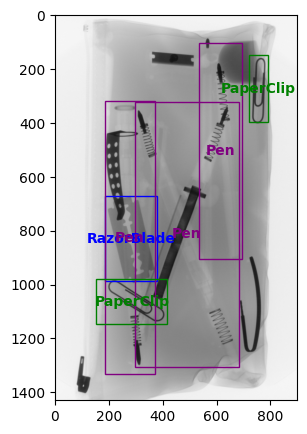

In [ ]:
# Plot original image and its box
img_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/train/images"
image_name = 'B0002_0001'
image_ext = '.png'
image = cv2.imread(img_folder_path + "/" + image_name + image_ext)
plt.rcParams["figure.figsize"] = (12,5)
plt.imshow(image)

box_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/train/labels"
height, width,_ = image.shape
f = open(box_folder_path+"/"+image_name + '.txt', 'r')
box_list = f.readlines()
plot_box(box_list, height, width)
box_list

['0 0.57972 0.685 0.220979 0.214444',
 '3 0.352098 0.317222 0.56014 0.176667',
 '3 0.568182 0.456111 0.688811 0.427778',
 '3 0.577273 0.691667 0.70979 0.207778',
 '2 0.18986 0.159444 0.174126 0.076667',
 '2 0.743357 0.682778 0.116084 0.292222']

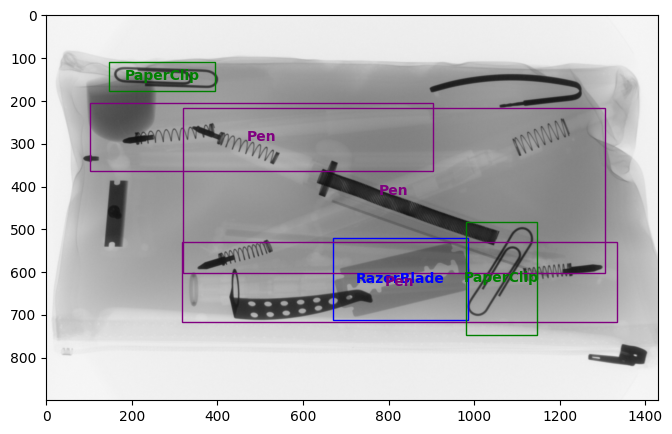

In [ ]:
# Rotate 90 degree
im = yoloRotatebbox(img_folder_path, box_folder_path, image_name, image_ext, 90)
image_90 = im.rotate_image()
bbox_90 = im.rotateYolobbox()
(height, width,_) = image_90.shape

plt.rcParams["figure.figsize"] = (12,5)
plt.imshow(image_90)
plot_box(bbox_90, height, width)
bbox_90

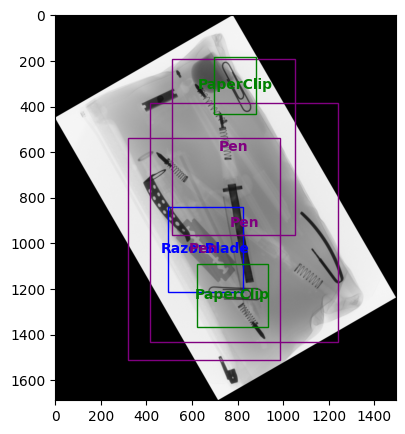

In [ ]:
# Rotate 30 degree
im = yoloRotatebbox(img_folder_path, box_folder_path, image_name, image_ext, 30)
image_30 = im.rotate_image()
bbox_30 = im.rotateYolobbox()
(height, width,_) = image_30.shape

plt.rcParams["figure.figsize"] = (12,5)
plt.imshow(image_30)
plot_box(bbox_30, height, width)

## Generate rotated images from existing images

In [22]:
def generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, from_degree, to_degree):
  '''
  Input: folder paths to extract image, annotation and folder paths to save rotated image, annotation
  Output: Rotated image and annotation are saved in designated folders
  '''
  # Extract image & annotation name
  image_list = [i for i in listdir(image_folder_path) if isfile(join(image_folder_path, i))]

  # Loop through each image
  count = 0
  for img in image_list:
    try:
      count = count + 1
      # Rotate image & box in yolo format
      name = img.split(".")[0]
      degree = random.randint(from_degree,to_degree)
      rotate = yoloRotatebbox(image_folder_path, annotation_folder_path, name, ".png", degree)
      rotate_img = rotate.rotate_image()
      rotate_box = rotate.rotateYolobbox()

      # Save image and box into destination folders
      cv2.imwrite(save_img_pth + "/" + 'rotated_' + name +'_' + str(degree) + '.png', rotate_img)
      file_name = save_annotation_path + "/" +'rotated_'+ name +'_' + str(degree) + '.txt'
      with open(file_name, 'w') as fp:
        for i in range(len(rotate_box)):
          if i < (len(rotate_box)-1):
            fp.write(rotate_box[i]+"\n") # add break line for items not the last one
          else:
            fp.write(rotate_box[i]) # no break line for last item (avoid empty row)
    except:
      count = count - 1
      pass # some images do not have dangerous objects => no annotation file
  print("Rotated",count,"images/ boxes at random degree in range [",from_degree,",",to_degree,"]")

In [8]:
# Get the folders
image_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/train/images"
annotation_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/train/labels"
save_img_pth = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/images"
save_annotation_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/labels"

In [24]:
# Check consistency of images & box
image_list = [i.split(".")[0] for i in listdir(image_folder_path) if isfile(join(image_folder_path, i))]
print("Number of image:", len(image_list))
box_list = [i.split(".")[0] for i in listdir(annotation_folder_path) if isfile(join(annotation_folder_path, i))]
print("Number of box:", len(box_list))

Number of image: 545
Number of box: 545


In [25]:
print("Have box file but don't have image:")
list(set(box_list) - set(image_list))

Have box file but don't have image:


[]

In [26]:
print("Have image but don't have box file:")
list(set(image_list) - set(box_list)) # some images do not have dangerous objects => no annotation file

Have image but don't have box file:


[]

In [27]:
# For each image, generate 3 images randomly rotated in defined ranges
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 1, 89)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 90, 90)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 91, 179)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 180, 180)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 181, 269)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 270, 270)
generate_rotated_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path, 271, 359)

Rotated 545 images/ boxes at random degree in range [ 1 , 89 ]
Rotated 545 images/ boxes at random degree in range [ 90 , 90 ]
Rotated 545 images/ boxes at random degree in range [ 91 , 179 ]
Rotated 545 images/ boxes at random degree in range [ 180 , 180 ]
Rotated 545 images/ boxes at random degree in range [ 181 , 269 ]
Rotated 545 images/ boxes at random degree in range [ 270 , 270 ]
Rotated 545 images/ boxes at random degree in range [ 271 , 359 ]


In [20]:
# Check consistency of rotated images & box
image_list = [i.split(".")[0] for i in listdir(save_img_pth) if isfile(join(save_img_pth, i))]
print("Number of rotated image:", len(image_list))
box_list = [i.split(".")[0] for i in listdir(save_annotation_path) if isfile(join(save_annotation_path, i))]
print("Number of rotated box:", len(box_list))

Number of rotated image: 4040
Number of rotated box: 4040


['0 0.685 0.42028 0.214444 0.220979\n',
 '3 0.317222 0.647902 0.176667 0.56014\n',
 '3 0.456111 0.431818 0.427778 0.688811\n',
 '3 0.691667 0.422727 0.207778 0.70979\n',
 '2 0.159444 0.81014 0.076667 0.174126\n',
 '2 0.682778 0.256643 0.292222 0.116084']

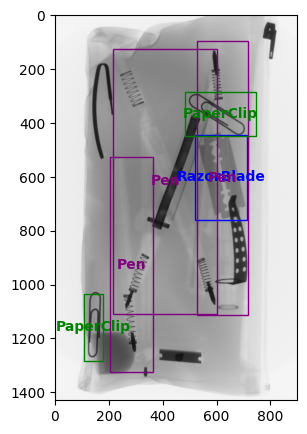

In [10]:
# Plot original image and its box
img_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/images"
image_name = 'rotated_B0002_0001_180'
image_ext = '.png'
image = cv2.imread(img_folder_path + "/" + image_name + image_ext)
plt.rcParams["figure.figsize"] = (12,5)
plt.imshow(image)

box_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/labels"
height, width,_ = image.shape
f = open(box_folder_path+"/"+image_name + '.txt', 'r')
box_list = f.readlines()
plot_box(box_list, height, width)
box_list

['0 0.57972 0.685 0.220979 0.214444\n',
 '3 0.352098 0.317222 0.56014 0.176667\n',
 '3 0.568182 0.456111 0.688811 0.427778\n',
 '3 0.577273 0.691667 0.70979 0.207778\n',
 '2 0.18986 0.159444 0.174126 0.076667\n',
 '2 0.743357 0.682778 0.116084 0.292222']

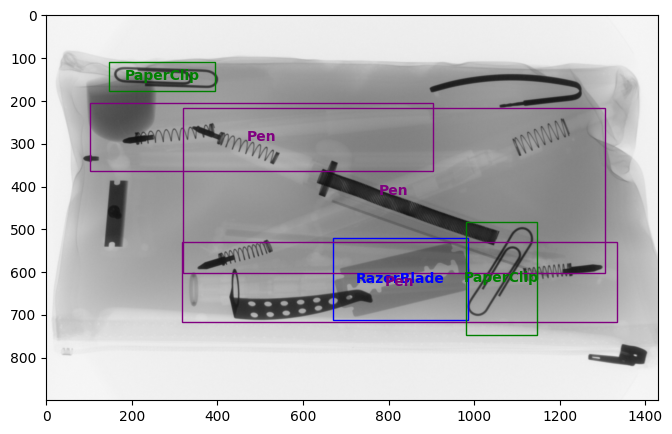

In [13]:
# Plot rotate image and its box
img_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/images"
image_name = 'rotated_B0002_0001_90'
image_ext = '.png'
image = cv2.imread(img_folder_path + "/" + image_name + image_ext)
plt.rcParams["figure.figsize"] = (12,5)
plt.imshow(image)

box_folder_path = "gdrive/MyDrive/CRP_Shared_Folder/CRP__Dataset_Repartition/training_with_rotateimg/labels"
height, width,_ = image.shape
f = open(box_folder_path+"/"+image_name + '.txt', 'r')
box_list = f.readlines()
plot_box(box_list, height, width)
box_list